# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator

import pandas as pd

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

# Nicer plotting
%config InlineBackend.figure_format = 'retina'

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict, a=2) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, linked_variables={})

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'f1': 0.11401572022703582,
 'xopt_runtime': 0.20034496499988563,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = vocs.random_inputs(10)
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error
0,0.529588,0.300432,False
1,1.154098,0.400540,False
2,0.641450,0.200399,False
3,0.619825,0.200362,False
4,0.536923,0.100229,False
5,0.342636,0.300477,False
6,0.589861,0.100277,False
7,0.556977,0.400550,False
8,0.055586,0.300431,False
9,0.785844,0.300478,False


In [10]:
# Dataframe submission (returns futures dict)
futures = ev.submit_data(in10)
for future in futures:
    print(future.result())

{'f1': 0.5295876188736232, 'xopt_runtime': 0.30045821000021533, 'xopt_error': False}
{'f1': 1.154097903998413, 'xopt_runtime': 0.3004508100000294, 'xopt_error': False}
{'f1': 0.641449645681512, 'xopt_runtime': 0.10022733599998901, 'xopt_error': False}
{'f1': 0.6198251611679085, 'xopt_runtime': 0.10033103699993262, 'xopt_error': False}
{'f1': 0.5369228584400957, 'xopt_runtime': 0.40060644699997283, 'xopt_error': False}
{'f1': 0.3426360721182605, 'xopt_runtime': 0.3004849099997955, 'xopt_error': False}
{'f1': 0.5898614653804399, 'xopt_runtime': 0.20036447300003601, 'xopt_error': False}
{'f1': 0.5569771979382582, 'xopt_runtime': 0.40057314699993185, 'xopt_error': False}
{'f1': 0.055585968775201305, 'xopt_runtime': 0.30044831000009253, 'xopt_error': False}
{'f1': 0.7858444543806786, 'xopt_runtime': 0.3004482090000238, 'xopt_error': False}


In [11]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error
0,0.529588,0.401368,False
1,1.154098,0.401368,False
2,0.641450,0.401368,False
3,0.619825,0.401368,False
4,0.536923,0.401368,False
5,0.342636,0.401368,False
6,0.589861,0.401368,False
7,0.556977,0.401368,False
8,0.055586,0.401368,False
9,0.785844,0.401368,False


In [12]:
# Vectorized submission. This returns a single future.
ev.vectorized = True
futures = ev.submit_data(in10)
len(futures)

1

In [13]:
futures[0].result()

{'f1': array([0.52958762, 1.1540979 , 0.64144965, 0.61982516, 0.53692286,
        0.34263607, 0.58986147, 0.5569772 , 0.05558597, 0.78584445]),
 'xopt_runtime': 0.40053584599991154,
 'xopt_error': False}

In [14]:
# Collect in a dataframe
res = futures[0].result()
# If there is an error, all outputs are spoiled.
if res['xopt_error']:
    res = [res]
pd.DataFrame(res)

,f1,xopt_runtime,xopt_error
0,0.529588,0.400536,False
1,1.154098,0.400536,False
2,0.641450,0.400536,False
3,0.619825,0.400536,False
4,0.536923,0.400536,False
5,0.342636,0.400536,False
6,0.589861,0.400536,False
7,0.556977,0.400536,False
8,0.055586,0.400536,False
9,0.785844,0.400536,False


# Executors

In [15]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
MAX_WORKERS = 10

In [16]:
# Create Executor insance
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [17]:
# Dask (Optional)
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [18]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS)

In [19]:
# This will run in parallel
ev.evaluate_data(in10)

,f1,xopt_runtime,xopt_error
0,0.529588,0.100659,False
1,1.154098,0.100625,False
2,0.641450,0.100556,False
3,0.619825,0.100801,False
4,0.536923,0.100516,False
5,0.342636,0.100752,False
6,0.589861,0.100588,False
7,0.556977,0.100648,False
8,0.055586,0.100518,False
9,0.785844,0.100804,False


# Evaluator in the Xopt object

In [20]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
1,0.333263,0.670598
2,0.127120,0.708698
3,0.478903,0.998964
4,0.249796,0.363820


In [21]:
# Internal futures dictionary
X._futures

{1: <Future at 0x7f7e10ae72b0 state=finished returned dict>,
 2: <Future at 0x7f7e10bbb220 state=finished returned dict>,
 3: <Future at 0x7f7e10bbbf40 state=finished returned dict>,
 4: <Future at 0x7f7e10bbb6a0 state=finished returned dict>}

In [22]:
# Collect all finished futures and updata dataframe
X.process_futures()
X.data

,x,y,f1,xopt_runtime,xopt_error
1,0.333263,0.670598,0.560765,0.400663,False
2,0.127120,0.708698,0.518413,0.400533,False
3,0.478903,0.998964,1.227277,0.400568,False
4,0.249796,0.363820,0.194763,0.400541,False


In [23]:
# Futures are now cleared out
X._futures

{}

In [24]:
# This is the internal counter
X._ix_last

4

In [25]:
# This causes immediate evaluation
X.evaluate_data(vocs.random_inputs(4))

,x,y,f1,xopt_runtime,xopt_error
5,0.600748,0.031670,0.361902,0.100265,False
6,0.596771,0.132335,0.373648,0.100352,False
7,0.665451,0.208765,0.486407,0.100249,False
8,0.276934,0.555539,0.385316,0.300462,False


In [26]:
# Singe generation step
X.step()
X.data

,x,y,f1,xopt_runtime,xopt_error
1,0.333263,0.670598,0.560765,0.400663,False
2,0.127120,0.708698,0.518413,0.400533,False
3,0.478903,0.998964,1.227277,0.400568,False
4,0.249796,0.363820,0.194763,0.400541,False
5,0.600748,0.031670,0.361902,0.100265,False
6,0.596771,0.132335,0.373648,0.100352,False
7,0.665451,0.208765,0.486407,0.100249,False
8,0.276934,0.555539,0.385316,0.300462,False
9,0.287898,0.757285,0.656366,0.100246,False


In [27]:
# Usage with a parallel executor. 
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [28]:
X2.step()

In [29]:
for _ in range(20):
    X2.step()

len(X2.data)

40

<AxesSubplot: xlabel='x', ylabel='y'>

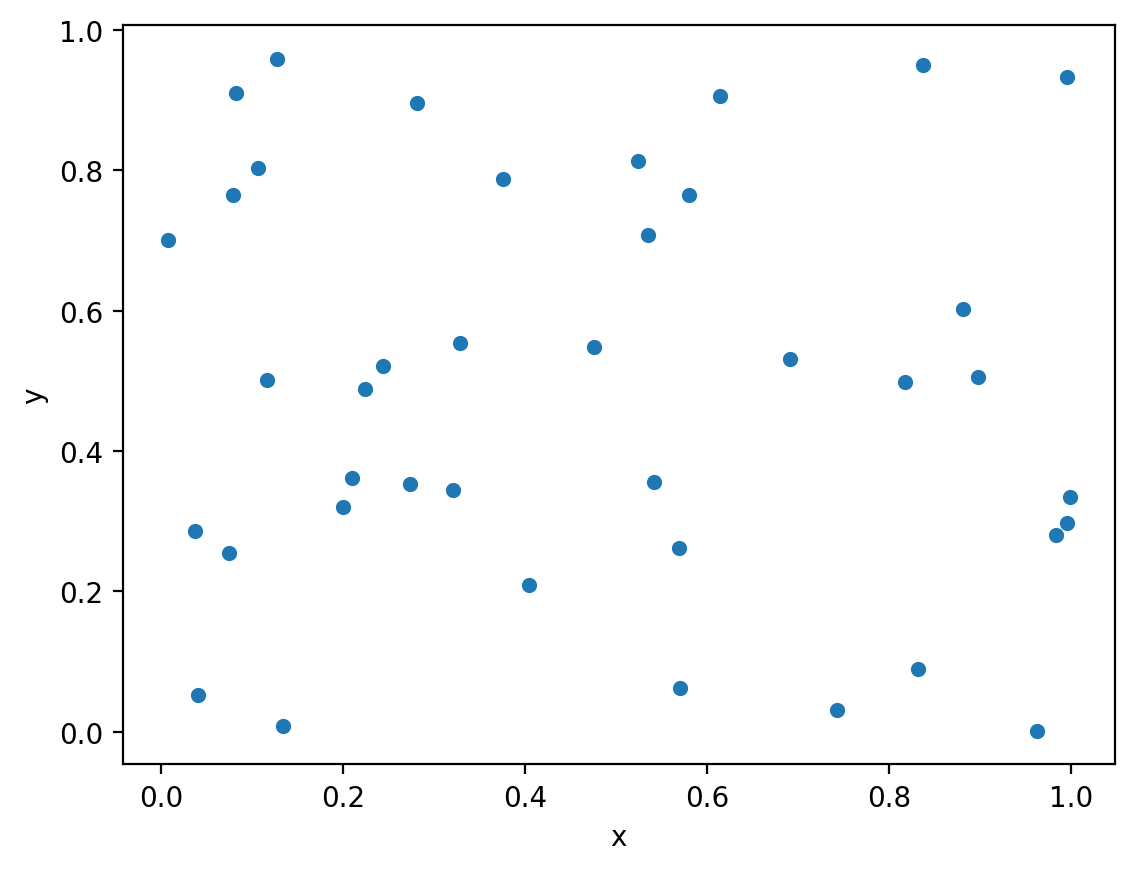

In [30]:
X2.data.plot.scatter("x", "y")

In [31]:
# Asynchronous, Vectorized
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True
X2.evaluator.vectorized = True

# This takes fewer steps to achieve a similar numver of evaluations
for _ in range(3):
    X2.step()

len(X2.data)

30